Imports

In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt

Load Data


In [10]:
with open('alllines.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
def decode(x):# decoder: take a list of integers, output a string
    return ''.join([itos[i] for i in x])
def encode(x):# encoder: take a string, output a list of integers
    return [stoi[c] for c in x]
data = torch.tensor(encode(text), dtype=torch.long)


print("Vocab Size",vocab_size)


def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])

    return x, y
#Split data into training and validation
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

Vocab Size 78


Make modules for Transformer block

In [11]:
class FeedForward(nn.Module):
  def __init__(self, d_model):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(d_model, 4 * d_model),
            nn.ReLU(),
            nn.Linear(4 * d_model, d_model),
            nn.Dropout(dropout),
        )
  def forward(self,x):
    return self.model(x)
class Head(nn.Module):
    def __init__(self, d_model, dk):
        super(Head, self).__init__()
        self.dk = dk
        self.key = nn.Linear(d_model, dk, bias=False)
        self.query = nn.Linear(d_model, dk, bias=False)
        self.value = nn.Linear(d_model, dk, bias=False)
        self.dropout=nn.Dropout(dropout)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)

        wei = (q @ k.transpose(-2,-1)) /(C**0.5)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # masking the block

        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        out = wei @ v
        return out
class MultiHead(nn.Module):
    def __init__(self, num_head, d_model, dk):
        super(MultiHead, self).__init__()
        self.num_head = num_head
        self.heads = nn.ModuleList([Head(d_model, dk) for _ in range(num_head)])
        self.linear_transform_O = nn.Linear(num_head * dk, d_model)
        self.dropout=nn.Dropout(dropout)

    def forward(self, x):

        head_outputs = [head(x) for head in self.heads]
        concatenated = torch.cat(head_outputs, dim=2) # Batch_size, seq_length, embedding_Size
        multi_head = self.linear_transform_O(concatenated)
        multi_head=self.dropout(multi_head)
        return multi_head

class DecoderOnlyBlock(nn.Module):
    def __init__(self, num_head, d_model):
        super().__init__()
        dk=d_model//num_head
        self.masked_multiHead = MultiHead(num_head, d_model, dk)
        self.non_Linear = FeedForward(d_model)
        self.layer_norm1 = nn.LayerNorm(d_model)
        self.layer_norm2 = nn.LayerNorm(d_model)
        self.layer_norm3 = nn.LayerNorm(d_model)

    def forward(self, decoder_input):
        x = self.masked_multiHead(decoder_input)
        # Add and Norm 1

        add_norm1 = self.layer_norm1(decoder_input + x)


        # Add and Norm 2
        add_norm2 = self.layer_norm2(add_norm1 + x)

        # Feed Forward
        x = self.non_Linear(add_norm2)

        # Add and Norm 3
        add_norm3 = self.layer_norm3(add_norm2 + x)
        return add_norm3


Assemble the modules to build a decoder Block


In [12]:
class My_GPT(nn.Module):
    def __init__(self, num_head, d_model, n_layer, vocab_size, context_size):
        super(My_GPT, self).__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, d_model)
        self.position_embedding_table = nn.Embedding(context_size, d_model)
        self.decoders = nn.Sequential(*[DecoderOnlyBlock(num_head, d_model) for _ in range(n_layer)]) # stack number of decoder
        self.non_Linear_Final = nn.Linear(d_model, vocab_size) # last layer of MLP before softmaxing
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x,targets=None):
        # embedd input add positional encoding as well
        ri, fi = x.shape
        word_embed=self.token_embedding_table(x)
        pos_embed=self.position_embedding_table(torch.arange(fi))
        pos_shape=pos_embed.shape
        word_shape=word_embed.shape
        embed=word_embed+pos_embed

        d=self.decoders(embed)
        s=self.norm(d)
        logits=self.non_Linear_Final(s) # batch_size
        if targets is  None:
            loss = None
        else:
            B, T, C = logits.shape
            # print(logits.shape)
            logits = logits.view(B*T, C)

            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)
            # loss=F.cross_entropy(s,target)
        return logits,loss
    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]# Get the Maximum amount of context

            logits, loss = self(idx_cond) # Infer on the context

            logits = logits[:, -1, :] # Grab the new logit

            probs = F.softmax(logits, dim=-1) # Softmax on the logit to get a distribution

            idx_next = torch.multinomial(probs, num_samples=1) # sample from the distibution

            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1) add the token to input to generate the next token
        return idx

Initialize HyperParameter

In [13]:
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000
eval_interval = 50
learning_rate = 1e-3
eval_iters = 200
n_embd = 64
n_head = 4 # heads in transformer
n_layer = 4 # number of autoRegression
dropout = 0.0

Training Stuff (takes some time)

In [14]:
@torch.no_grad()
def estimate_loss():
    model.eval()
    losses = torch.zeros(eval_iters)

    for k in range(eval_iters):
          X, Y = get_batch('val')
          logits, loss = model(X, Y)
          losses[k] = loss.item()
    e=losses.mean()
    return e

model = My_GPT(n_head,n_embd,n_layer,vocab_size,block_size)


optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
los=list()
for iter in range(max_iters):

    if iter % eval_interval == 0 :
        losses = estimate_loss()
        los.append(losses)

    xb, yb = get_batch('train')

    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

Plotting Loss

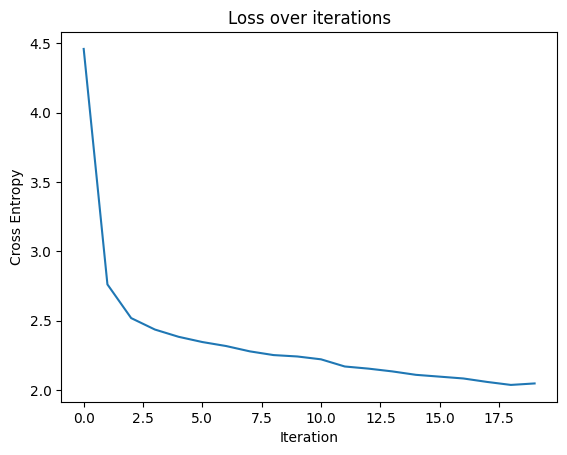

In [15]:
plt.plot(los)

# Adding labels to the axes
plt.xlabel('Iteration')
plt.ylabel('Cross Entropy')

# Adding a title to the plot
plt.title('Loss over iterations')

# Displaying the plot
plt.show()

Infrence

In [20]:
context = torch.randint(0, vocab_size, (1, 1))# to start infrence pick a random token to start on
how_much_token_to_generate=1000
infer=decode(model.generate(context, max_new_tokens=how_much_token_to_generate)[0].tolist())
print(infer)

seee of domargh."
"Row his avear coustim peffes mistait the the hadyestur to mug,"
"Nit ut disch im so inden youser'ouscqe wilister?"
"And sharee pet, which lich. marth towes as ag?"
"He Geir thigs shougst ibl cose is bok:"
"Nou arthans feat the salll and and, in lid,"
"Whow  sfelymave a os me therttranctuace."
"AS thisp, sow thake sof kelts art thid"
"o's and must andelr noo. mid Wost with, nowird thered: he asst cooain."
"I hellll be are ofer lave seann feat Of"
"Ait yellit if of Blimbps thistong a Imph swervous, Clak which uthaftstaund,"
"Wholll and der Garadeetebl and dnowad,"
"Or arwespseisy coust. and but gros muss highrds I tmings, sfaron is ar sliff: rrevave or: chist doghim,"
"Tthem thath bedender wiko min, thaglert of thak:"
"Te apoked over waik."
"Thaglt, my as Leak atouref,"
"Pour notherse for diseat lood uodsar'es-ye dimerin'dn at of ithin."
"A hest moll ae, sir if Gotar for"
"It to bod whath on de wighar to welthat"
"Ver this cose hid sordyon ther warsed The wich cer aty'